In [1]:
import pandas as pd
import numpy as np
import time
import random
import lightgbm as lgb
import time

import pickle
import matplotlib.pyplot as plt

In [2]:
from process import gen_second_data

In [3]:
FOLDER = '../../data_kaggle/champs/'
OUTPUT = FOLDER + 'out/'

In [4]:
second_train = "20190715_second_train.pickle"
second_val = "20190715_second_val.pickle"
second_test = "20190715_second_test.pickle"
first = "20190715_dist_ang_ori_bond_cos_train_1JHC.pickle"

In [5]:
df_val_temp = pd.read_pickle(OUTPUT + second_val)
df_train_temp = pd.read_pickle(OUTPUT + second_train)

In [6]:
df_feat = pd.read_pickle(OUTPUT + first).fillna(0)

In [7]:
df_feat.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,dist_H_0_x,dist_H_1_x,dist_H_2_x,dist_H_3_x,...,orientation_O_2_y,dist_F_0_y,dist_F_1_y,angle_F_0_y,angle_F_1_y,orientation_F_0_y,orientation_F_1_y,cos_3j,cos_3j^2,dist_center
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,0.560815,0.560806,0.560803,0.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
1,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,0.560815,0.560806,0.560803,0.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2,7,dsgdb9nsd_000001,3,0,1JHC,84.8093,0.560806,0.560806,0.560803,0.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
3,9,dsgdb9nsd_000001,4,0,1JHC,84.8095,0.560806,0.560806,0.560803,0.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
4,17,dsgdb9nsd_000005,2,0,1JHC,171.2200,0.000000,0.000000,0.000000,0.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0


In [8]:
df_train_temp.columns[:6]

Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant'],
      dtype='object')

In [9]:
df_train = pd.merge(df_feat, df_train_temp, \
                    left_on=['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type','scalar_coupling_constant'],
                    right_on=['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type','scalar_coupling_constant'])

In [10]:
df_val = pd.merge(df_feat, df_val_temp, \
                    left_on=['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type','scalar_coupling_constant'],
                    right_on=['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type','scalar_coupling_constant'])

In [27]:
rounds = 200000
params = {
        'task' : 'train',
        'boosting_type' : 'gbdt',
        'objective' : 'regression',
        'metric' : {'l1'},
        'num_leaves' : 63,
        'learning_rate' : 0.005,
        'feature_fraction' : 0.5,
        'bagging_fraction' : 0.5,
        'bagging_freq': 5,
    'seed':0
}

In [28]:
def type_score(y_val, y_pred):
    return np.log(sum(np.abs(y_val- y_pred)) / len(y_val))

In [29]:
bond = "1JHC"
y_train = df_train.query('type=="{}"'.format(bond))['scalar_coupling_constant'].values
X_train = df_train.query('type=="{}"'.format(bond))[df_train.columns[6:]].values

y_val = df_val.query('type=="{}"'.format(bond))['scalar_coupling_constant'].values
X_val = df_val.query('type=="{}"'.format(bond))[df_val.columns[6:]].values

In [30]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

In [31]:
start = time.time()
gbm = lgb.train(params,
        lgb_train,
        num_boost_round=rounds,
        verbose_eval=0,
        valid_sets=lgb_eval,
        early_stopping_rounds=30)
elapsed_time = time.time() - start
print ("elapsed_time:%.2f" % elapsed_time + "[sec]")

elapsed_time:3797.74[sec]


In [32]:
y_val_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)

In [33]:
print(gbm.best_iteration)
print("score first model: %.2f" %  (type_score(y_val, X_val[:, -26])))
print("score second model: %.2f" %  (type_score(y_val, y_val_pred)))

121566
score first model: -0.78
score second model: -0.80


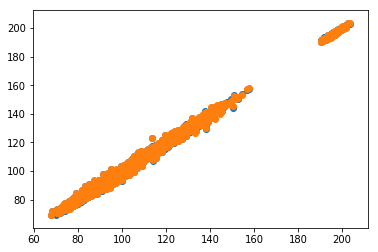

In [34]:
plt.scatter(y_val, X_val[:, -26])
plt.scatter(y_val, y_val_pred)
plt.show()

In [35]:
gbm.feature_importance()

array([ 54559,  61089,  73271,  54011,  42779,  35297,  29059,  22829,
        18090,  15329,  49663,  57123,  66233,  60813,  55598,  47605,
        39847,  29621,  22650,  15750,  28887,  58997,  61597,  59795,
        55002,  49300,  40888,  31796,  23688,  16617,  79015,  47852,
        41361,  46132,  44629,  37273,  24544,  10097,   2423,      0,
            0,  54878,  55130,  58040,  53112,  45578,  28183,  12295,
         2787,      0,      0,  48126,  56626,  55398,  50830,  46306,
        28764,  10821,   1606,      0,  55393,  54362,  56947,  58425,
        55895,  46114,  28426,  11228,   2316,      0,  65030,  44426,
        51230,  53937,  50626,  41135,  25675,   9551,   2016,      0,
        46209,  18597,   7130,  40324,  17808,   7113,  28977,  14027,
         4658,  30996,  14700,   6352,  19005,   8069,   3249,  76403,
        42816,  11769,  66007,  35140,  10040,  47353,  30424,   7094,
         2165,    948,   1510,    758,   1030,    362,  59291,  51587,
      

In [36]:
df_imp = pd.Series(gbm.feature_importance(), index=df_train.query('type=="{}"'.format(bond))[df_train.columns[6:]].columns)

In [38]:
df_imp

dist_H_0_x            54559
dist_H_1_x            61089
dist_H_2_x            73271
dist_H_3_x            54011
dist_H_4_x            42779
dist_H_5_x            35297
dist_H_6_x            29059
dist_H_7_x            22829
dist_H_8_x            18090
dist_H_9_x            15329
angle_H_0_x           49663
angle_H_1_x           57123
angle_H_2_x           66233
angle_H_3_x           60813
angle_H_4_x           55598
angle_H_5_x           47605
angle_H_6_x           39847
angle_H_7_x           29621
angle_H_8_x           22650
angle_H_9_x           15750
orientation_H_0_x     28887
orientation_H_1_x     58997
orientation_H_2_x     61597
orientation_H_3_x     59795
orientation_H_4_x     55002
orientation_H_5_x     49300
orientation_H_6_x     40888
orientation_H_7_x     31796
orientation_H_8_x     23688
orientation_H_9_x     16617
                      ...  
orientation_F_1_y       722
cos_3j                    0
cos_3j^2                  0
dist_center               0
0                   